In [48]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
from os.path import dirname, realpath
from singleNeuron_omega import preSpikes, nextSpikes, STDPLIFDensePopulation, convergence_level, get_metrics, get_metrics_long_pat

# Cargamos y graficamos la salida de la FC

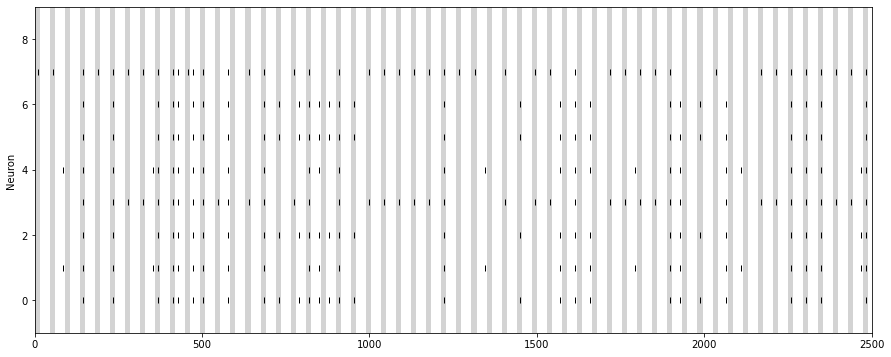

(<AxesSubplot:ylabel='Neuron '>, None)

In [49]:
plt.rcParams["figure.figsize"] =(15,6)
Sprobe_fc = torch.load('./sequences/massive_runs/1/fc_outputs/all_nums_5/training/0/fc_output_8_w0-7_th4-0.pt').numpy()
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums/training/0/pat_all_nums.npy')

sv_utils.plotLIF(U=None, S=Sprobe_fc[30000:32500], pat_times=pat_times[30000:32500])

# Entrenamos a la Single Neuron con la salida de la FC

In [54]:
Sin = torch.tensor(Sprobe_fc).float()
T = Sin.shape[0]
N_out = 1
N_in = Sin.shape[1]
th = 2.7

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.75, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.00010125, a_minus=.000125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 15  # Cantidad de timesteps que miro hacia atras
dt_ltd = 60  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 300000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))
        

# Una vez finalizado el entrenamiento, obtenemos la salida sin entrenear
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()


iter: 500 convergence: 0.1198826143776861
iter: 1000 convergence: 0.11600841728855293
iter: 1500 convergence: 0.11212736103729792
iter: 2000 convergence: 0.10716720621994513
iter: 2500 convergence: 0.10347621967607967
iter: 3000 convergence: 0.09997530983863268
iter: 3500 convergence: 0.0976795369401513
iter: 4000 convergence: 0.09248862867700058
iter: 4500 convergence: 0.08821895196452534
iter: 5000 convergence: 0.08590370768261346
iter: 5500 convergence: 0.08365003415581374
iter: 6000 convergence: 0.0804589837048546
iter: 6500 convergence: 0.07817458718590231
iter: 7000 convergence: 0.073927777432516
iter: 7500 convergence: 0.07105051858520639
iter: 8000 convergence: 0.06614394349588171
iter: 8500 convergence: 0.06094189490964297
iter: 9000 convergence: 0.05698982430947641
iter: 9500 convergence: 0.054258647079509004
iter: 10000 convergence: 0.05042572642474408
iter: 10500 convergence: 0.04707798034333388
iter: 11000 convergence: 0.045108031088040956
iter: 11500 convergence: 0.043384

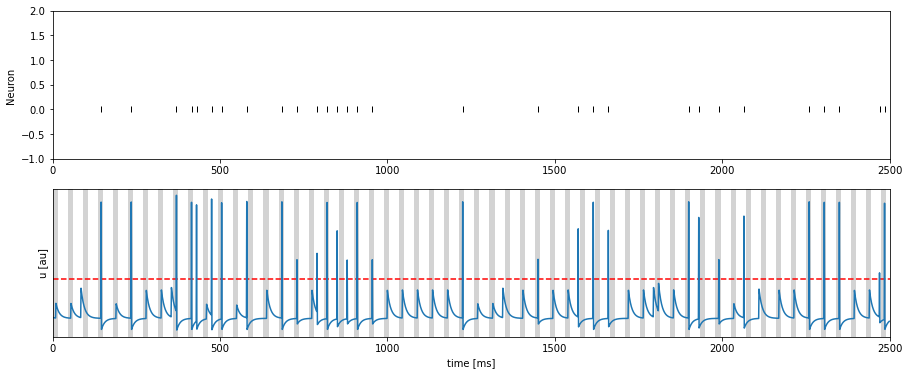

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [55]:
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums/training/0/pat_all_nums.npy')
sv_utils.plotLIF(U=Uprobe[30000:32500], S=Sprobe[30000:32500], pat_times=pat_times[30000:32500], th=2.7)

# Probamos la secuencia de Testing

In [56]:
Sin = torch.load('./sequences/massive_runs/1/fc_outputs/all_nums_5/testing/0/fc_output_8_w0-7_th3-0.pt')
T = Sin.shape[0] 

#singleNeuron.th = 3.5

# Una vez finalizado el entrenamiento, obtenemos la salida sin entrenear
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()

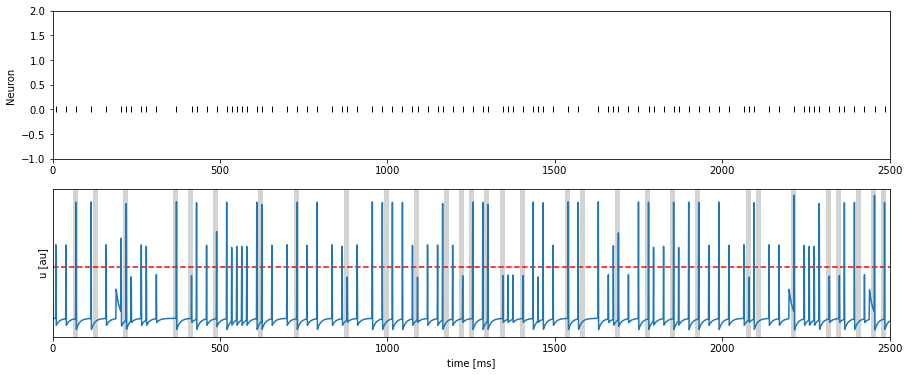

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [57]:
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums_5/testing/0/pat_test_all_nums_5.npy')
sv_utils.plotLIF(U=Uprobe[30000:32500], S=Sprobe[30000:32500], pat_times=pat_times[30000:32500], th=3.5)